In [1]:
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from geopandas.tools import overlay
import matplotlib.pyplot as plt
import os 
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
import xgboost as xgb
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, mean_squared_error
#import tensorflow as tf
#from keras.models import Sequential
#from keras.layers import Dense
#from tensorflow.keras.utils import to_categorical

## Espacios Públicos GDL

In [2]:
schema = 'espacios_publicos'
table = 'ep_amg'
gdf_gdl = aup.gdf_from_db(table,schema)
print(gdf_gdl.shape)
gdf_gdl.head(2)

(8499, 4)


,Fuente,Tipo,Uso,geometry
0,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672507.028 2272132.201, 672520.126 2..."
1,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672520.126 2272170.353, 672507.028 2..."


Filter data

In [3]:
gdf_gdl.Tipo.unique()

array(['Parque', 'Espacio verde vecinal', 'Glorieta', 'Camellón',
       'Área natural', 'Unidad deportiva', 'Plaza',
       'Área natural protegida'], dtype=object)

In [4]:
gdf_gdl = gdf_gdl.loc[(gdf_gdl.Tipo!='Glorieta')&(gdf_gdl.Tipo!='Camellón')].copy()
print(gdf_gdl.shape)

(4100, 4)


## Espacios Públicos QRO

In [5]:
schema = 'espacios_publicos'
table = 'ep_qro'
gdf_qro = aup.gdf_from_db(table,schema)
print(gdf_qro.shape)
gdf_qro.head(2)

(4814, 9)


,geografico,nombre,tipo,cveserv,cvegeo,geometria,fechaact,condicion,geometry
0,Bordo,Ninguno,No Aplica,036,220010001,Area,12/2007,No Aplica,"POLYGON ((-100.14119 20.18851, -100.14112 20.1..."
1,Bordo,Ninguno,No Aplica,037,220010001,Area,12/2007,No Aplica,"POLYGON ((-100.13606 20.18186, -100.13603 20.1..."


In [6]:
gdf_qro.tipo.unique()

array(['No Aplica', 'Intermitente', 'CamellÃ\xa0n', 'Lienzo Charro',
       'Otro', 'Glorieta', 'Urbana', 'CamellÃ³n', 'Perenne',
       'Zona Industrial', 'Tanque Elevado', 'Granja o Establo',
       'Tiradero', 'Caja de Agua', 'Diverso', 'Monumento u Obelisco',
       'Planta de Tratamiento de Agua'], dtype=object)

Eliminar Querétaro

## Espacios Públicos CDMX

In [7]:
schema = 'espacios_publicos'
table = 'ep_cdmx'
gdf_cdmx = aup.gdf_from_db(table,schema)
print(gdf_cdmx.shape)
gdf_cdmx.head(2)

(11609, 13)


,id,geo_point_2d,geo_shape,subcat_sed,subcve_sed,gid,cve_delg,delegacion,categoria,superficie,perimetro,cve_sedema,geometry
0,0,"19.4877568178,-99.2060645931","{'type': 'MultiPolygon', 'coordinates': [[[[-9...",Panteones,604,268,2,Azcapotzalco,Equipamientos urbanos con vegetación,6660.027554,329.264738,600,"POLYGON ((-99.20639 19.48819, -99.20556 19.487..."
1,1,"19.3887689803,-99.116393168","{'type': 'MultiPolygon', 'coordinates': [[[[-9...",Deportivos,601,87,8,Iztacalco,Equipamientos urbanos con vegetación,2917.257837,272.2436142,600,"POLYGON ((-99.11679 19.38904, -99.11637 19.388..."


In [8]:
gdf_cdmx.categoria.unique()

array(['Equipamientos urbanos con vegetación',
       'Áreas verdes complementarias o ligadas a la red vial',
       'Plazas y jardines', 'Parques, arboledas y alamedas',
       'Áreas verdes urbanas fragmentadas',
       'Áreas verdes con estructura urbana',
       'Áreas con categoría de protección',
       'Áreas con vegetación reminisciente',
       'Áreas con características de protección'], dtype=object)

In [9]:
gdf_cdmx.subcat_sed.unique()

array(['Panteones', 'Deportivos', 'Camellones centrales y laterales',
       'Unidades habitacionales', 'Instituciones académicas públicas',
       'Plazas', 'Asistencia Social con vegetación CDMX', 'Parques',
       'Veg. Arbórea, arbustiva y herbácea de glorietas', 'Vialidades',
       'Instituciones académicas privadas', 'Arboledas',
       'Instituciones de salud pub/priv', 'Jardines públicos', 'Canales',
       'Jardineras públicas y privadas', 'Azoteas verdes', 'Bordos',
       'Terrenos baldíos', 'AVA', 'Depresiones orográficas', 'ANP',
       'Alamedas', 'Promontorios', 'Colinas', 'Cerros',
       'Zona de recarga de manto acuíferos'], dtype=object)

Filter data

In [10]:
gdf_cdmx = gdf_cdmx[gdf_cdmx['subcat_sed'].isin(['Deportivos','Plazas','Parques',
                                     'Arboledas','Jardines públicos','Jardineras públicas y privadas',
                                     'ANP','Alamedas'])]
print(gdf_cdmx.shape)

(2427, 13)


## Juntamos en un dataset

In [11]:
gdf_gdl = gdf_gdl.to_crs("EPSG:4326")
# gdf_qro = gdf_qro.set_crs("EPSG:4326", allow_override=True)
gdf_cdmx = gdf_cdmx.to_crs("EPSG:4326")
print("CRS of gdf_gdl:", gdf_gdl.crs)
# print("CRS of gdf_qro:", gdf_qro.crs)
print("CRS of gdf_cdmx:", gdf_cdmx.crs)

CRS of gdf_gdl: EPSG:4326
CRS of gdf_cdmx: EPSG:4326


In [12]:
geodataframes = [gdf_gdl, gdf_cdmx]
ep_gdf = pd.concat(geodataframes)
ep_gdf = ep_gdf[['geometry']]
ep_gdf.head()

,geometry
0,"POLYGON ((-103.34533 20.54017, -103.3452 20.54..."
1,"POLYGON ((-103.3452 20.54051, -103.34533 20.54..."
2,"POLYGON ((-103.34546 20.53983, -103.34559 20.5..."
3,"POLYGON ((-103.34559 20.53952, -103.34546 20.5..."
4,"POLYGON ((-103.34571 20.53916, -103.34583 20.5..."


In [13]:
ep_gdf.shape

(6527, 1)

### Delete GeoDataFrames

In [14]:
del gdf_gdl
del gdf_cdmx
del geodataframes

## Hexágonos 3 ciudades

In [15]:
hex_schema = "raster_analysis"
hex_table = "ndvi_analysis_hex"
# hex_table_tempt = "temperature_analysis_hex"
# hex_schema_pob = "hexgrid"
# hex_table_pob = "hexgrid_9_city_2020"
c1 = 'Guadalajara'
c2 ='CDMX'
#c3 = 'Querétaro'
n = '11'
query = f"""
SELECT h1.hex_id, h1.geometry, h1.city 
FROM {hex_schema}.{hex_table} h1
WHERE h1.city IN ('{c1}', '{c2}') AND h1.res = {n}
"""
hex_gdf = aup.gdf_from_query(query, geometry_col='geometry')
#query = 'fSelect geometry, hex_id, city from raster_analysis.ndvi_analysis where city = guadalajara and res = 11'
print(hex_gdf.shape)
hex_gdf.head(5)

(906258, 3)


,hex_id,geometry,city
0,8b499584a09afff,"POLYGON ((-99.17332 19.35547, -99.17314 19.355...",CDMX
1,8b499584a082fff,"POLYGON ((-99.17391 19.35431, -99.17374 19.354...",CDMX
2,8b499584a081fff,"POLYGON ((-99.17479 19.3544, -99.17461 19.3546...",CDMX
3,8b499584a091fff,"POLYGON ((-99.17345 19.35451, -99.17327 19.354...",CDMX
4,8b499584a083fff,"POLYGON ((-99.17432 19.3546, -99.17414 19.3548...",CDMX


In [16]:
'''hex_schema = "raster_analysis"
hex_table = "ndvi_analysis_hex"
hex_table_tempt = "temperature_analysis_hex"
hex_schema_pob = "hexgrid"
hex_table_pob = "hexgrid_9_city_2020"
c1 = 'Guadalajara'
c2 ='CDMX'
#c3 = 'Querétaro'
n = '11'
query = f"""
SELECT h1.hex_id, h1.geometry, h1.city 
FROM {hex_schema}.{hex_table} h1
JOIN {hex_schema}.{hex_table_tempt} h2
ON h1.hex_id = h2.hex_id
WHERE h1.city IN ('{c1}', '{c2}') AND h1.res = {n}
"""
hex_gdf = aup.gdf_from_query(query, geometry_col='geometry')
#query = 'fSelect geometry, hex_id, city from raster_analysis.ndvi_analysis where city = guadalajara and res = 11'
hex_gdf.head(5)'''

'hex_schema = "raster_analysis"\nhex_table = "ndvi_analysis_hex"\nhex_table_tempt = "temperature_analysis_hex"\nhex_schema_pob = "hexgrid"\nhex_table_pob = "hexgrid_9_city_2020"\nc1 = \'Guadalajara\'\nc2 =\'CDMX\'\n#c3 = \'Querétaro\'\nn = \'11\'\nquery = f"""\nSELECT h1.hex_id, h1.geometry, h1.city \nFROM {hex_schema}.{hex_table} h1\nJOIN {hex_schema}.{hex_table_tempt} h2\nON h1.hex_id = h2.hex_id\nWHERE h1.city IN (\'{c1}\', \'{c2}\') AND h1.res = {n}\n"""\nhex_gdf = aup.gdf_from_query(query, geometry_col=\'geometry\')\n#query = \'fSelect geometry, hex_id, city from raster_analysis.ndvi_analysis where city = guadalajara and res = 11\'\nhex_gdf.head(5)'

In [17]:
hex_gdf['city'].unique()

array(['CDMX', 'Guadalajara'], dtype=object)

In [18]:
contador_gdl = np.sum(hex_gdf['city'] == 'Guadalajara')
contador_cdmx = np.sum(hex_gdf['city'] == 'CDMX')
#contador_qroo = np.sum(hex_gdl['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx}')

Número de hexágonos Gdl: 493251 
Número de hexágonos Cdmx: 413007


In [19]:
hex_gdf = hex_gdf.to_crs("EPSG:4326")
print("CRS of hex_gdf:", hex_gdf.crs)

CRS of hex_gdf: EPSG:4326


In [20]:
# contador_gdl = np.sum(hex_gdl['city'] == 'Guadalajara')
# contador_cdmx = np.sum(hex_gdl['city'] == 'CDMX')
# contador_qro = np.sum(hex_gdf['city'] == 'Queretaro')
# print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx}')

### Plot data

<Axes: >

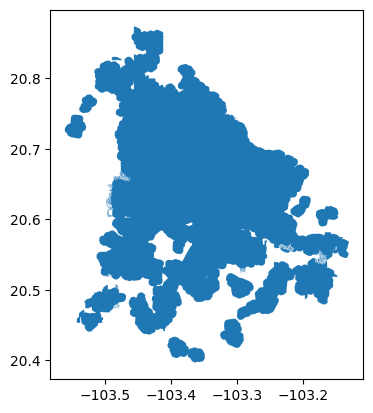

In [21]:
hex_gdf.loc[hex_gdf.city=='Guadalajara'].dissolve().plot()

<Axes: >

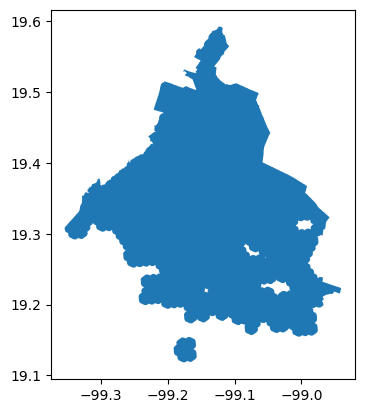

In [22]:
hex_gdf.loc[hex_gdf.city=='CDMX'].dissolve().plot()

## Dummy Variables
1 = Hexágonos que cuentan con espacios públicos

0 = Hexágonos que no cuentan con espacios públicos

In [23]:
gdf_sindex = ep_gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
intersects_public_spaces = hex_gdf['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

hex_gdf['EspPublico'] = intersects_public_spaces.astype(int)
hex_gdf.head()

,hex_id,geometry,city,EspPublico
0,8b499584a09afff,"POLYGON ((-99.17332 19.35547, -99.17314 19.355...",CDMX,0
1,8b499584a082fff,"POLYGON ((-99.17391 19.35431, -99.17374 19.354...",CDMX,0
2,8b499584a081fff,"POLYGON ((-99.17479 19.3544, -99.17461 19.3546...",CDMX,0
3,8b499584a091fff,"POLYGON ((-99.17345 19.35451, -99.17327 19.354...",CDMX,0
4,8b499584a083fff,"POLYGON ((-99.17432 19.3546, -99.17414 19.3548...",CDMX,0


In [24]:
contador_ceros = np.sum(hex_gdf['EspPublico'] == 0)
contador_uno = np.sum(hex_gdf['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno}\nNúmero total de Hexágonos: {contador_ceros+contador_uno}')

Números de hexagonos sin Espacios Públicos: 779728 
Número de Hexágonos con Espacios Públicos: 126530
Número total de Hexágonos: 906258


## Hexágonos con info de humedad, vegetación y temperatura

select {ndmi}.hex_id, {ndmi}.geometry, {ndmi}.city, {ndmi}.res,

ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend,

ndmi_mean, ndmi_median, ndmi_diff

from raster_analysis.ndmi_analysis_hex ndmi

inner join raster_analysis.ndvi_analysis_hex ndvi

on ndmi.hex_id = ndvi.hex_id 

where ndmi.city  in ('Queretaro','Guadalajara','ZMVM') and ndmi.res = 11

In [25]:
hex_schema = "raster_analysis"
hex_schema_pob = "hexgrid"
hex_tablee = "ndvi_analysis_hex"
hex_table = "ndmi_analysis_hex"
hex_table_pob = "hexgrid_9_city_2020"
hex_table_tempt = "temperature_analysis_hex"
ndmi = "ndmi"
ndvi = "ndvi"
temp = "temp"
poblation = "POBTOT"
hex_id = "hex_id"
c1 = 'Guadalajara'
c2 ='CDMX'
#c3 = 'Queretaro'
n = '11'

query = f'''
SELECT 
    temp.hex_id, 
    temp.city, 
    temp.geometry AS geometry,  
    temp.res AS temp_res,
    ndmi.geometry AS ndmi_geometry, 
    ndmi.city AS ndmi_city, 
    ndmi.res AS ndmi_res, 
    ndvi.geometry AS ndvi_geometry, 
    ndvi.city AS ndvi_city, 
    ndvi.res AS ndvi_res, 
    ndvi.ndvi_mean, 
    ndvi.ndvi_std, 
    ndvi.ndvi_median, 
    ndvi.ndvi_max, 
    ndvi.ndvi_min, 
    ndvi.ndvi_diff, 
    ndvi.ndvi_tend,
    ndmi.ndmi_mean, 
    ndmi.ndmi_median, 
    ndmi.ndmi_diff, 
    temp.temp_diff_mean
FROM 
    {hex_schema}.{hex_table_tempt} temp  
INNER JOIN 
    {hex_schema}.{hex_table} ndmi 
    ON temp.hex_id = ndmi.hex_id
INNER JOIN 
    {hex_schema}.{hex_tablee} ndvi 
    ON ndmi.hex_id = ndvi.hex_id
WHERE 
    temp.city IN ('{c1}', '{c2}') 
    AND temp.res = {n}
'''

variables_gdf = aup.gdf_from_query(query, geometry_col='geometry')
variables_gdf.head(10)

,hex_id,city,geometry,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,...,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean
0,8b499584a09efff,CDMX,"POLYGON ((-99.17338 19.35499, -99.17321 19.355...",11,0103000020E61000000100000007000000F4E2C2B118CB...,CDMX,11,0103000020E61000000100000007000000F4E2C2B118CB...,CDMX,11,...,0.165089,0.637277,0.648746,0.489500,0.159245,-0.005960,0.133597,0.133750,0.035030,-6.167781
1,8b499584ec18fff,CDMX,"POLYGON ((-99.1749 19.32304, -99.17473 19.3232...",11,0103000020E61000000100000007000000DBF1FD9F31CB...,CDMX,11,0103000020E61000000100000007000000DBF1FD9F31CB...,CDMX,11,...,0.086048,0.276264,0.332943,0.206213,0.126730,-0.003039,0.010773,0.012479,0.092037,0.716390
2,8b4995b33b88fff,CDMX,"POLYGON ((-99.27068 19.36009, -99.2705 19.3603...",11,0103000020E61000000100000007000000650F40D452D1...,CDMX,11,0103000020E61000000100000007000000650F40D452D1...,CDMX,11,...,0.090337,0.204179,0.306329,0.141536,0.164793,-0.002508,0.024188,0.023533,0.055633,-4.336916
3,8b4995b10240fff,CDMX,"POLYGON ((-99.24543 19.40416, -99.24525 19.404...",11,0103000020E61000000100000007000000B20E951FB5CF...,CDMX,11,0103000020E61000000100000007000000B20E951FB5CF...,CDMX,11,...,0.077126,0.384305,0.405471,0.319468,0.086003,-0.002697,0.029371,0.027726,0.033596,-3.247859
4,8b4995b13c5efff,CDMX,"POLYGON ((-99.23086 19.41382, -99.23069 19.414...",11,0103000020E6100000010000000700000000FE7C7DC6CE...,CDMX,11,0103000020E6100000010000000700000000FE7C7DC6CE...,CDMX,11,...,0.073966,0.366528,0.374647,0.301152,0.073495,-0.002484,0.052856,0.052747,0.030628,-0.771514
5,8b4995b138a1fff,CDMX,"POLYGON ((-99.23615 19.41072, -99.23597 19.410...",11,0103000020E61000000100000007000000F6D7A6081DCF...,CDMX,11,0103000020E61000000100000007000000F6D7A6081DCF...,CDMX,11,...,0.064977,0.305529,0.311444,0.248205,0.063239,-0.002394,0.011068,0.013627,0.035536,-0.927933
6,8b4995b10a5dfff,CDMX,"POLYGON ((-99.24946 19.39704, -99.24929 19.397...",11,0103000020E6100000010000000700000068195630F7CF...,CDMX,11,0103000020E6100000010000000700000068195630F7CF...,CDMX,11,...,0.059015,0.286967,0.290063,0.232440,0.057623,-0.001883,0.010934,0.012096,0.030306,-1.318420
7,8b4995b10136fff,CDMX,"POLYGON ((-99.23662 19.39009, -99.23644 19.390...",11,0103000020E61000000100000007000000744AB4CA24CF...,CDMX,11,0103000020E61000000100000007000000744AB4CA24CF...,CDMX,11,...,0.191683,0.395473,0.675044,0.249684,0.425359,-0.004925,0.008398,-0.019589,0.270427,-4.405942
8,8b4995b13d48fff,CDMX,"POLYGON ((-99.23305 19.41064, -99.23288 19.410...",11,0103000020E610000001000000070000008F414B58EACE...,CDMX,11,0103000020E610000001000000070000008F414B58EACE...,CDMX,11,...,0.152638,0.581121,0.643812,0.446240,0.197571,-0.005795,0.068674,0.063930,0.101890,-3.686011
9,8b4995b10733fff,CDMX,"POLYGON ((-99.23281 19.39894, -99.23263 19.399...",11,0103000020E6100000010000000700000099DB734CE6CE...,CDMX,11,0103000020E6100000010000000700000099DB734CE6CE...,CDMX,11,...,0.126412,0.517656,0.632631,0.412143,0.220488,-0.003840,0.107257,0.113969,0.081395,-4.090452


In [26]:
variables_gdf.shape

(807653, 21)

In [27]:
variables_gdf['city'].unique()

array(['CDMX', 'Guadalajara'], dtype=object)

In [28]:
contador_gdl = np.sum(variables_gdf['city'] == 'Guadalajara')
contador_cdmx = np.sum(variables_gdf['city'] == 'CDMX')
#intt_qroo = np.sum(intt_gdl['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx}')

Número de hexágonos Gdl: 445881 
Número de hexágonos Cdmx: 361772


## Intersección

In [53]:
# intt_gdl = intt_gdl.set_crs("EPSG:4326")
# hex_gdl = hex_gdl.set_crs("EPSG:4326")

In [29]:
variables_gdf = variables_gdf.merge(hex_gdf[['hex_id','EspPublico']], on='hex_id',
                      how='left')
print(variables_gdf.shape)
variables_gdf.head()

In [30]:
# inter.drop(columns=['index_right','city_right','hex_id_right'], inplace=True)
# inter.rename(columns={"hex_id_left": "hex_id","city_left": "city"}, inplace=True)

(968415, 22)


,hex_id,city,geometry,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,...,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean,EspPublico
0,8b499584a09efff,CDMX,"POLYGON ((-99.17338 19.35499, -99.17321 19.355...",11,0103000020E61000000100000007000000F4E2C2B118CB...,CDMX,11,0103000020E61000000100000007000000F4E2C2B118CB...,CDMX,11,...,0.637277,0.648746,0.489500,0.159245,-0.005960,0.133597,0.133750,0.035030,-6.167781,0
1,8b499584ec18fff,CDMX,"POLYGON ((-99.1749 19.32304, -99.17473 19.3232...",11,0103000020E61000000100000007000000DBF1FD9F31CB...,CDMX,11,0103000020E61000000100000007000000DBF1FD9F31CB...,CDMX,11,...,0.276264,0.332943,0.206213,0.126730,-0.003039,0.010773,0.012479,0.092037,0.716390,0
2,8b4995b33b88fff,CDMX,"POLYGON ((-99.27068 19.36009, -99.2705 19.3603...",11,0103000020E61000000100000007000000650F40D452D1...,CDMX,11,0103000020E61000000100000007000000650F40D452D1...,CDMX,11,...,0.204179,0.306329,0.141536,0.164793,-0.002508,0.024188,0.023533,0.055633,-4.336916,1
3,8b4995b10240fff,CDMX,"POLYGON ((-99.24543 19.40416, -99.24525 19.404...",11,0103000020E61000000100000007000000B20E951FB5CF...,CDMX,11,0103000020E61000000100000007000000B20E951FB5CF...,CDMX,11,...,0.384305,0.405471,0.319468,0.086003,-0.002697,0.029371,0.027726,0.033596,-3.247859,0
4,8b4995b13c5efff,CDMX,"POLYGON ((-99.23086 19.41382, -99.23069 19.414...",11,0103000020E6100000010000000700000000FE7C7DC6CE...,CDMX,11,0103000020E6100000010000000700000000FE7C7DC6CE...,CDMX,11,...,0.366528,0.374647,0.301152,0.073495,-0.002484,0.052856,0.052747,0.030628,-0.771514,0


Remove rows with NaN

In [31]:
# inter['temp_diff_mean'] = inter['temp_diff_mean'].fillna(0)
variables_gdf = variables_gdf.dropna()
print(variables_gdf.shape)

(968405, 22)


Count data

In [32]:
contador_gdl = np.sum(variables_gdf['city'] == 'Guadalajara')
contador_cdmx = np.sum(variables_gdf['city'] == 'CDMX')
#contador_qro = np.sum(inter['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx}')

Número de hexágonos Gdl: 606633 
Número de hexágonos Cdmx: 361772


In [33]:
cont_no_ep = np.sum(variables_gdf['EspPublico'] == 0)
cont_ep = np.sum(variables_gdf['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {cont_no_ep} \nNúmero de Hexágonos con Espacios Públicos: {cont_ep}\nNúmero total de Hexágonos: {cont_no_ep+cont_ep}')

Números de hexagonos sin Espacios Públicos: 814728 
Número de Hexágonos con Espacios Públicos: 153677
Número total de Hexágonos: 968405


## Submuestreo 162,410 Hexágonos Esp Púb x 162,410 Hexágonos No Esp Púb

In [34]:
num_samples = len(variables_gdf[variables_gdf['EspPublico'] == 1]) # selecciona variables de acuerdo con el total de hexagonos con ep

# Randomly sample 203,570 hexagons with public spaces
sample_with_public_spaces = variables_gdf[variables_gdf['EspPublico'] == 1].sample(n=num_samples, random_state=42)

# Randomly sample 203,570 hexagons without public spaces
sample_without_public_spaces = variables_gdf[variables_gdf['EspPublico'] == 0].sample(n=num_samples, random_state=42)

# Concatenate the two samples to get the final subsample
variables_gdf = pd.concat([sample_with_public_spaces, sample_without_public_spaces])
variables_gdf.reset_index(drop = True, inplace = True)
print(variables_gdf.shape)
variables_gdf.head()

(307354, 22)


,hex_id,city,geometry,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,...,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean,EspPublico
0,8b498c923388fff,Guadalajara,"POLYGON ((-103.19353 20.5642, -103.19336 20.56...",11,0103000020E610000001000000070000006B489FCD62CC...,Guadalajara,11,0103000020E610000001000000070000006B489FCD62CC...,Guadalajara,11,...,0.304928,0.650626,0.124198,0.526428,-0.002952,-0.037013,-0.090418,0.321522,2.258221,1
1,8b49ab4b6380fff,Guadalajara,"POLYGON ((-103.39873 20.72443, -103.39856 20.7...",11,0103000020E61000000100000007000000D6F92ED484D9...,Guadalajara,11,0103000020E61000000100000007000000D6F92ED484D9...,Guadalajara,11,...,0.079199,0.087597,0.061990,0.025607,-0.000812,-0.050142,-0.049632,0.026506,1.243396,1
2,8b498c94b95efff,Guadalajara,"POLYGON ((-103.35355 20.75432, -103.35338 20.7...",11,0103000020E61000000100000007000000FE21499CA0D6...,Guadalajara,11,0103000020E61000000100000007000000FE21499CA0D6...,Guadalajara,11,...,0.239734,0.407088,0.139557,0.267531,-0.001098,0.007947,0.000454,0.182614,-0.505518,1
3,8b49aa2ceb0afff,Guadalajara,"POLYGON ((-103.35569 20.55558, -103.35551 20.5...",11,0103000020E610000001000000070000002FBB648BC3D6...,Guadalajara,11,0103000020E610000001000000070000002FBB648BC3D6...,Guadalajara,11,...,0.473158,0.701672,0.242874,0.458798,-0.002858,0.077509,0.054081,0.240285,-1.192010,1
4,8b498c9416d2fff,Guadalajara,"POLYGON ((-103.32494 20.71368, -103.32477 20.7...",11,0103000020E61000000100000007000000CA021FD9CBD4...,Guadalajara,11,0103000020E61000000100000007000000CA021FD9CBD4...,Guadalajara,11,...,0.344811,0.418801,0.264267,0.154534,-0.002717,0.051648,0.048946,0.076891,-inf,1


In [35]:
cont_no_ep = np.sum(variables_gdf['EspPublico'] == 0)
contador_ep = np.sum(variables_gdf['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {cont_no_ep} \nNúmero de Hexágonos con Espacios Públicos: {contador_ep}\nNúmero total de Hexágonos: {cont_no_ep+contador_ep}')

Números de hexagonos sin Espacios Públicos: 153677 
Número de Hexágonos con Espacios Públicos: 153677
Número total de Hexágonos: 307354


### Del data

In [36]:
del sample_with_public_spaces
del sample_without_public_spaces

## Download population data

Download urban hexagons by city

In [37]:
hex_schema_pob = "hexgrid"
hex_table_pob = "hexgrid_9_city_2020"
c1 = 'Guadalajara'
c2 = 'CDMX'
n = "9"
t = "urban"

#Consulta para la tabla de población (solo tipo urbano y ciudades seleccionadas):
query_pob = f"""
SELECT * 
FROM {hex_schema_pob}.{hex_table_pob} 
WHERE city IN ('{c1}', '{c2}') 
AND type = '{t}'
"""

hex_urban = aup.gdf_from_query(query_pob, geometry_col='geometry')
print(hex_urban.shape)
hex_urban.head(5)

(13629, 6)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban
1,89498c960a3ffff,"POLYGON ((-103.34713 20.62771, -103.34591 20.6...",14039,Guadalajara,Guadalajara,urban
2,89498c97333ffff,"POLYGON ((-103.27379 20.66284, -103.27257 20.6...",14039,Guadalajara,Guadalajara,urban
3,89498c96063ffff,"POLYGON ((-103.33352 20.63689, -103.3323 20.63...",14039,Guadalajara,Guadalajara,urban
4,89498c95cb3ffff,"POLYGON ((-103.29386 20.71601, -103.29264 20.7...",14039,Guadalajara,Guadalajara,urban


Download hexagons with population data by city

In [38]:
#Consulta para la tabla de manzanas (solo ciudades seleccionadas):
hex_schema_mza = "censo"
hex_table_mza = "hex_censo_mza_2020_res9"

query_mza = f"""
SELECT hex_id_9, pobtot, geometry
FROM {hex_schema_mza}.{hex_table_mza} WHERE
hex_id_9 IN {str(tuple(hex_urban.hex_id_9.unique()))}
"""
hex_pop = aup.gdf_from_query(query_mza, geometry_col='geometry')
print(hex_pop.shape)
hex_pop.head(2)

(11815, 3)


,hex_id_9,pobtot,geometry
0,894995b1507ffff,1159.0,"POLYGON ((-99.26246 19.38575, -99.26122 19.387..."
1,8949958cc9bffff,1717.0,"POLYGON ((-99.04364 19.3746, -99.0424 19.37617..."


In [51]:
# pob = hex_gdl_pob.shape
# mza = hex_gdl_mza.shape

# print(pob)
# print(mza)

In [41]:
# hex_pop['city'].unique()

In [46]:
'''hex_schema_mza = "censo"
hex_schema_pob = "hexgrid"
hex_table_pob = "hexgrid_9_city_2020"
hex_table_mza = "hex_censo_mza_2020_res9"
c1 = 'Guadalajara'
c2 = 'CDMX'
t = "urban"


query_join = f"""
SELECT pob.hex_id_9, pob.city, pob.type, mza.pobtot, mza.geometry
FROM {hex_schema_pob}.{hex_table_pob} pob
INNER JOIN {hex_schema_mza}.{hex_table_mza} mza
ON pob.hex_id_9 = mza.hex_id_9
WHERE pob.city IN ('{c1}', '{c2}') 
AND pob.type = '{t}'
"""

hex_gdl_join = aup.gdf_from_query(query_join, geometry_col='geometry')

hex_gdl_join.head(5)'''


,hex_id_9,city,type,pobtot,geometry
0,894995b1507ffff,CDMX,urban,1159.0,"POLYGON ((-99.26246 19.38575, -99.26122 19.387..."
1,894995b2277ffff,CDMX,urban,736.0,"POLYGON ((-99.30773 19.3479, -99.3065 19.34948..."
2,89499584547ffff,CDMX,urban,1265.0,"POLYGON ((-99.17964 19.28341, -99.17841 19.284..."
3,8949958cc9bffff,CDMX,urban,1717.0,"POLYGON ((-99.04364 19.3746, -99.0424 19.37617..."
4,89499585e13ffff,CDMX,urban,3163.0,"POLYGON ((-99.11471 19.32935, -99.11347 19.330..."


In [47]:
# contador_gdl_join = np.sum(hex_gdl_join['city'] == 'Guadalajara')
# contador_cdmxx_join = np.sum(hex_gdl_join['city'] == 'CDMX')
# print(f'Número de hexágonos Gdl: {contador_gdl_join} \nNúmero de hexágonos Cdmx: {contador_cdmxx_join}')

Número de hexágonos Gdl: 5650 
Número de hexágonos Cdmx: 6165


In [48]:
# hex_gdl_join = hex_gdl_join.set_crs("EPSG:4326", allow_override=True)
# print("CRS of gdf_gdl:", gdf_gdl.crs)

CRS of gdf_gdl: EPSG:4326


## Dummy Variables
1 = Hexágonos que cuentan con espacios públicos

0 = Hexágonos que no cuentan con espacios públicos

In [44]:
# gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
# intersects_public_spaces = hex_gdl_join['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

# hex_gdl_join['EspPublico'] = intersects_public_spaces.astype(int)
# hex_gdl_join.head()

,hex_id_9,city,type,pobtot,geometry,EspPublico
0,894995b1507ffff,CDMX,urban,1159.0,"POLYGON ((-99.26246 19.38575, -99.26122 19.387...",1
1,894995b2277ffff,CDMX,urban,736.0,"POLYGON ((-99.30773 19.34790, -99.30650 19.349...",0
2,89499584547ffff,CDMX,urban,1265.0,"POLYGON ((-99.17964 19.28341, -99.17841 19.284...",1
3,8949958cc9bffff,CDMX,urban,1717.0,"POLYGON ((-99.04364 19.37460, -99.04240 19.376...",1
4,89499585e13ffff,CDMX,urban,3163.0,"POLYGON ((-99.11471 19.32935, -99.11347 19.330...",1


In [45]:
# contador_ceros_join = np.sum(hex_gdl_join['EspPublico'] == 0)
# contador_uno_join = np.sum(hex_gdl_join['EspPublico'])
# print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros_join} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno_join}\nNúmero total de Hexágonos: {contador_ceros_join + contador_uno_join}')

Números de hexagonos sin Espacios Públicos: 7364 
Número de Hexágonos con Espacios Públicos: 4451
Número total de Hexágonos: 11815


## Intersección espacial

In [46]:
# pd.isna(hex_gdl_join).sum()

hex_id_9      0
city          0
type          0
pobtot        0
geometry      0
EspPublico    0
dtype: int64

In [47]:
# hex_gdl_pob = hex_gdl_pob.set_crs("EPSG:4326")
# hex_gdl_mza = hex_gdl_mza.set_crs("EPSG:4326")

In [48]:
# inter_join = gpd.sjoin(hex_gdl_pob, hex_gdl_mza, op='intersects')
# print(inter_join)

         hex_id_9_left                                           geometry  \
0      89498c96e0bffff  POLYGON ((-103.35267 20.66765, -103.35145 20.6...   
82     89498c96ecfffff  POLYGON ((-103.35003 20.66229, -103.34881 20.6...   
333    89498c96e47ffff  POLYGON ((-103.34935 20.66910, -103.34813 20.6...   
389    89498c96e1bffff  POLYGON ((-103.35301 20.66425, -103.35179 20.6...   
721    89498c96e57ffff  POLYGON ((-103.34969 20.66569, -103.34847 20.6...   
...                ...                                                ...   
13594  894995b96d3ffff  POLYGON ((-99.05118 19.43500, -99.04994 19.436...   
13534  894995b96cfffff  POLYGON ((-99.05030 19.44172, -99.04906 19.443...   
13550  894995b9657ffff  POLYGON ((-99.04985 19.44507, -99.04861 19.446...   
13570  894995b96cbffff  POLYGON ((-99.04746 19.43971, -99.04622 19.441...   
13570  894995b96cbffff  POLYGON ((-99.04746 19.43971, -99.04622 19.441...   

      CVEGEO               NOMGEO         city   type  index_right  \
0    

In [49]:
# inter_join.drop(columns=['index_right', 'hex_id_9_right'], inplace=True)
# inter_join.rename(columns={"hex_id_9_left": "hex_id_9"}, inplace=True)
# inter_join.head()

,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,pobtot
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban,975.0
82,89498c96ecfffff,"POLYGON ((-103.35003 20.66229, -103.34881 20.6...",14039,Guadalajara,Guadalajara,urban,975.0
333,89498c96e47ffff,"POLYGON ((-103.34935 20.66910, -103.34813 20.6...",14039,Guadalajara,Guadalajara,urban,975.0
389,89498c96e1bffff,"POLYGON ((-103.35301 20.66425, -103.35179 20.6...",14039,Guadalajara,Guadalajara,urban,975.0
721,89498c96e57ffff,"POLYGON ((-103.34969 20.66569, -103.34847 20.6...",14039,Guadalajara,Guadalajara,urban,975.0


In [50]:
# pd.isna(inter_join).sum()

hex_id_9    0
geometry    0
CVEGEO      0
NOMGEO      0
city        0
type        0
pobtot      0
dtype: int64

Extract centroids for spatial intersection

In [42]:
hex_cnt = hex_gdf.copy()
hex_cnt['geometry'] = hex_cnt.to_crs("EPSG:6372").centroid # set to meter projection and extract centroid
hex_cnt = hex_cnt.to_crs("EPSG:4326")
print(hex_cnt.shape)
hex_cnt.head(2)

(906258, 4)


,hex_id,geometry,city,EspPublico
0,8b499584a09afff,POINT (-99.17343 19.35572),CDMX,0
1,8b499584a082fff,POINT (-99.17403 19.35457),CDMX,0


Plot data

<Axes: >

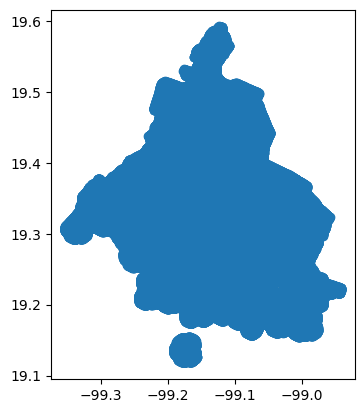

In [43]:
hex_cnt.loc[hex_cnt.city=='CDMX'].plot()

Spatial intersection between hexagons centroids with res 11 and hexagons with res 9

In [44]:
hex_cnt = hex_cnt.sjoin(hex_pop[['pobtot','geometry']])
print(hex_cnt.shape)
hex_cnt.head(2)

(644334, 6)


,hex_id,geometry,city,EspPublico,index_right,pobtot
0,8b499584a09afff,POINT (-99.17343 19.35572),CDMX,0,2206,233.0
1,8b499584a082fff,POINT (-99.17403 19.35457),CDMX,0,2206,233.0


Pass population data to variables_gdf

In [45]:
variables_gdf = variables_gdf.merge(hex_cnt[['hex_id','pobtot']], on='hex_id', how='inner')
print(variables_gdf.shape)
variables_gdf.head(2)

(343477, 23)


,hex_id,city,geometry,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,...,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean,EspPublico,pobtot
0,8b498c923388fff,Guadalajara,"POLYGON ((-103.19353 20.5642, -103.19336 20.56...",11,0103000020E610000001000000070000006B489FCD62CC...,Guadalajara,11,0103000020E610000001000000070000006B489FCD62CC...,Guadalajara,11,...,0.650626,0.124198,0.526428,-0.002952,-0.037013,-0.090418,0.321522,2.258221,1,251.0
1,8b498c923388fff,Guadalajara,"POLYGON ((-103.19353 20.5642, -103.19336 20.56...",11,0103000020E610000001000000070000006B489FCD62CC...,Guadalajara,11,0103000020E610000001000000070000006B489FCD62CC...,Guadalajara,11,...,0.650626,0.124198,0.526428,-0.002952,-0.037013,-0.090418,0.321522,2.258221,1,251.0


In [ ]:
# gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
#  intersects_public_spaces = inter_join['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

# inter_join['EspPublico'] = intersects_public_spaces.astype(int)
# inter_join.head()

In [46]:
cont_ceros = np.sum(variables_gdf['EspPublico'] == 0)
cont_uno = np.sum(variables_gdf['EspPublico'] == 1)
print(f'Números de hexagonos sin Espacios Públicos: {cont_ceros} \nNúmero de Hexágonos con Espacios Públicos: {cont_uno}\nNúmero total de Hexágonos: {cont_ceros + cont_uno}')

Números de hexagonos sin Espacios Públicos: 161919 
Número de Hexágonos con Espacios Públicos: 181558
Número total de Hexágonos: 343477


## [SKIP] Submuestreo población

In [53]:
num_samples_join = len(inter_join[inter_join['EspPublico'] == 1])

# Randomly sample 80632 hexagons with public spaces
sample_with_public_spaces_join = inter_join[inter_join['EspPublico'] == 1].sample(n=num_samples_join, random_state=42)

# Randomly sample 80632 hexagons without public spaces
sample_without_public_spaces_join = inter_join[inter_join['EspPublico'] == 0].sample(n=num_samples_join, random_state=42)

# Concatenate the two samples to get the final subsample
inter_join = pd.concat([sample_with_public_spaces_join, sample_without_public_spaces_join])
inter_join.reset_index(drop = True, inplace = True)
inter_join.head()

,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,pobtot,EspPublico
0,8949958518bffff,"POLYGON ((-99.11824 19.30248, -99.11700 19.304...",09003,Coyoacán,CDMX,urban,1007.0,1
1,89499585b53ffff,"POLYGON ((-99.12210 19.36758, -99.12086 19.369...",09007,Iztapalapa,CDMX,urban,2065.0,1
2,89499585287ffff,"POLYGON ((-99.08155 19.29861, -99.08031 19.300...",09007,Iztapalapa,CDMX,urban,1755.0,1
3,8949958eb2fffff,"POLYGON ((-99.07006 19.38592, -99.06882 19.387...",09006,Iztacalco,CDMX,urban,3394.0,1
4,8949958455bffff,"POLYGON ((-99.17397 19.27941, -99.17273 19.280...",09012,Tlalpan,CDMX,urban,1429.0,1


In [54]:
contador_ceros_join = np.sum(inter_join['EspPublico'] == 0)
contador_uno_join = np.sum(inter_join['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros_join} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno_join}\nNúmero total de Hexágonos: {contador_ceros_join + contador_uno_join}')

Números de hexagonos sin Espacios Públicos: 30868 
Número de Hexágonos con Espacios Públicos: 30868
Número total de Hexágonos: 61736


In [55]:
inter_join.shape

(61736, 8)

## [SKIP] Intersección espacial con población, vegetación, humedad y temperatura.

In [56]:
gdl_samples_inter = 222941
cdmx_samples_inter = 180886


# Randomly sample 200,000 hexagons of Guadalajra
sample_with_Guadalajara = inter[inter['city'] == 'Guadalajara'].sample(n=gdl_samples_inter, random_state=42)

# Randomly sample 150,000 hexagons of Cdmx
sample_with_Cdmx = inter[inter['city'] == 'CDMX'].sample(n=cdmx_samples_inter, random_state=42)

# Concatenate the two samples to get the final subsample
inter = pd.concat([sample_with_Guadalajara, sample_with_Cdmx])
inter.reset_index(drop = True, inplace = True)
inter.head()

,hex_id,geometry,city,EspPublico,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,...,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean
0,8b49ab4a2761fff,"POLYGON ((-103.46140 20.74234, -103.46122 20.7...",Guadalajara,0,11,0103000020E6100000010000000700000011F73E9087DD...,Guadalajara,11,0103000020E6100000010000000700000011F73E9087DD...,Guadalajara,...,0.196324,0.313934,0.686440,0.143196,0.543244,-0.000868,-0.004237,-0.057025,0.474585,1.637735
1,8b49ab4960c4fff,"POLYGON ((-103.36781 20.77978, -103.36763 20.7...",Guadalajara,0,11,0103000020E61000000100000007000000270C082091D7...,Guadalajara,11,0103000020E61000000100000007000000270C082091D7...,Guadalajara,...,0.126909,0.720346,0.744929,0.596078,0.148851,-0.004267,0.162811,0.159931,0.082315,-4.371524
2,8b498c9446d1fff,"POLYGON ((-103.30738 20.67617, -103.30720 20.6...",Guadalajara,0,11,0103000020E610000001000000070000006B0ABD47A4D3...,Guadalajara,11,0103000020E610000001000000070000006B0ABD47A4D3...,Guadalajara,...,0.035641,0.186702,0.204319,0.151394,0.052925,-0.001061,-0.050604,-0.048989,0.035194,1.532847
3,8b49aa2c3789fff,"POLYGON ((-103.31883 20.55254, -103.31866 20.5...",Guadalajara,0,11,0103000020E6100000010000000700000098FC2A8C6FD4...,Guadalajara,11,0103000020E6100000010000000700000098FC2A8C6FD4...,Guadalajara,...,0.075117,0.219712,0.307175,0.145248,0.161927,-0.002050,-0.019775,-0.026326,0.092838,-1.708328
4,8b49aa24e934fff,"POLYGON ((-103.51139 20.47468, -103.51122 20.4...",Guadalajara,0,11,0103000020E61000000100000007000000D38D23D3B9E0...,Guadalajara,11,0103000020E61000000100000007000000D38D23D3B9E0...,Guadalajara,...,0.020924,0.123073,0.153738,0.093353,0.060386,-0.000192,-0.043428,-0.044029,0.094701,-inf


In [57]:
contador_gdl = np.sum(inter['city'] == 'Guadalajara')
contador_cdmx = np.sum(inter['city'] == 'CDMX')
print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx}')

Número de hexágonos Gdl: 222941 
Número de hexágonos Cdmx: 180886


In [58]:
inter = inter.set_crs("EPSG:4326")
inter_join = inter_join.set_crs("EPSG:4326")

In [59]:
# Simplificar las geometrías
inter['geometry'] = inter['geometry'].simplify(tolerance=0.01)
inter_join['geometry'] = inter_join['geometry'].simplify(tolerance=0.01)

# Realizar la intersección con geometrías simplificadas
simplified_intersection = gpd.overlay(inter, inter_join, how='intersection')


In [60]:
simplified_intersection.head()

,hex_id,city_1,EspPublico_1,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,...,ndmi_diff,temp_diff_mean,hex_id_9,CVEGEO,NOMGEO,city_2,type,pobtot,EspPublico_2,geometry
0,8b498c90b54cfff,Guadalajara,0,11,0103000020E610000001000000070000005CF2BC1488CC...,Guadalajara,11,0103000020E610000001000000070000005CF2BC1488CC...,Guadalajara,11,...,0.423406,-3.518013,89498c90b57ffff,14101,Tonalá,Guadalajara,urban,222.0,0,"POLYGON ((-103.19611 20.66741, -103.19581 20.6..."
1,8b498c90b55dfff,Guadalajara,0,11,0103000020E610000001000000070000007CCD575979CC...,Guadalajara,11,0103000020E610000001000000070000007CCD575979CC...,Guadalajara,11,...,0.392792,-4.151091,89498c90b57ffff,14101,Tonalá,Guadalajara,urban,222.0,0,"POLYGON ((-103.19516 20.66782, -103.19486 20.6..."
2,8b498c90b548fff,Guadalajara,0,11,0103000020E610000001000000070000000660CA4687CC...,Guadalajara,11,0103000020E610000001000000070000000660CA4687CC...,Guadalajara,11,...,0.440299,-3.715834,89498c90b57ffff,14101,Tonalá,Guadalajara,urban,222.0,0,"POLYGON ((-103.19606 20.66790, -103.19576 20.6..."
3,8b498c90b54cfff,Guadalajara,0,11,0103000020E610000001000000070000005CF2BC1488CC...,Guadalajara,11,0103000020E610000001000000070000005CF2BC1488CC...,Guadalajara,11,...,0.423406,-3.518013,89498c90b57ffff,14101,Tonalá,Guadalajara,urban,503.0,0,"POLYGON ((-103.19611 20.66741, -103.19581 20.6..."
4,8b498c90b55dfff,Guadalajara,0,11,0103000020E610000001000000070000007CCD575979CC...,Guadalajara,11,0103000020E610000001000000070000007CCD575979CC...,Guadalajara,11,...,0.392792,-4.151091,89498c90b57ffff,14101,Tonalá,Guadalajara,urban,503.0,0,"POLYGON ((-103.19516 20.66782, -103.19486 20.6..."


In [61]:
simplified_intersection.drop(columns=["city_1", "EspPublico_1"], inplace=True)
simplified_intersection.rename(columns={"city_2": "city", "EspPublico_2": "EspPublico"}, inplace=True)
simplified_intersection.head()

,hex_id,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,ndvi_mean,ndvi_std,...,ndmi_diff,temp_diff_mean,hex_id_9,CVEGEO,NOMGEO,city,type,pobtot,EspPublico,geometry
0,8b498c90b54cfff,11,0103000020E610000001000000070000005CF2BC1488CC...,Guadalajara,11,0103000020E610000001000000070000005CF2BC1488CC...,Guadalajara,11,0.414017,0.217957,...,0.423406,-3.518013,89498c90b57ffff,14101,Tonalá,Guadalajara,urban,222.0,0,"POLYGON ((-103.19611 20.66741, -103.19581 20.6..."
1,8b498c90b55dfff,11,0103000020E610000001000000070000007CCD575979CC...,Guadalajara,11,0103000020E610000001000000070000007CCD575979CC...,Guadalajara,11,0.426913,0.217324,...,0.392792,-4.151091,89498c90b57ffff,14101,Tonalá,Guadalajara,urban,222.0,0,"POLYGON ((-103.19516 20.66782, -103.19486 20.6..."
2,8b498c90b548fff,11,0103000020E610000001000000070000000660CA4687CC...,Guadalajara,11,0103000020E610000001000000070000000660CA4687CC...,Guadalajara,11,0.402150,0.215642,...,0.440299,-3.715834,89498c90b57ffff,14101,Tonalá,Guadalajara,urban,222.0,0,"POLYGON ((-103.19606 20.66790, -103.19576 20.6..."
3,8b498c90b54cfff,11,0103000020E610000001000000070000005CF2BC1488CC...,Guadalajara,11,0103000020E610000001000000070000005CF2BC1488CC...,Guadalajara,11,0.414017,0.217957,...,0.423406,-3.518013,89498c90b57ffff,14101,Tonalá,Guadalajara,urban,503.0,0,"POLYGON ((-103.19611 20.66741, -103.19581 20.6..."
4,8b498c90b55dfff,11,0103000020E610000001000000070000007CCD575979CC...,Guadalajara,11,0103000020E610000001000000070000007CCD575979CC...,Guadalajara,11,0.426913,0.217324,...,0.392792,-4.151091,89498c90b57ffff,14101,Tonalá,Guadalajara,urban,503.0,0,"POLYGON ((-103.19516 20.66782, -103.19486 20.6..."


## PCA

In [51]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

features = ['pobtot', 'ndvi_mean', 'ndvi_std', 'ndvi_median', 'ndvi_max', 'ndvi_min', 'ndvi_diff', 
            'ndvi_tend', 'ndmi_mean', 'ndmi_median', 'ndmi_diff', 'temp_diff_mean']

df_features = variables_gdf[features]
df_features.replace([np.inf, -np.inf], np.nan, inplace=True)
df_features.fillna(df_features.mean(), inplace=True)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_features)

pca = PCA(n_components= 5)  #Cambia n_components si necesitas más o menos dimensiones
pca_components = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2', "PCA3", "PCA4","PCA5"])

# simplified_intersection = simplified_intersection.reset_index(drop=True)
variables_gdf['PCA1'] = pca_df['PCA1']
variables_gdf['PCA2'] = pca_df['PCA2']
variables_gdf["PCA3"] = pca_df["PCA3"]
variables_gdf["PCA4"] = pca_df["PCA4"]
variables_gdf["PCA5"] = pca_df["PCA5"]




In [52]:
# Aplicar PCA con todos los componentes
pca = PCA(n_components=len(features))
pca.fit(scaled_features)

# Varianza explicada por cada componente
explained_variance_ratio = pca.explained_variance_ratio_

# Varianza acumulada
cumulative_variance = np.cumsum(explained_variance_ratio)

In [53]:
#Varianza explicada por cada componente:
explained_variance_ratio = pca.explained_variance_ratio_

#Varianza acumulada:
cumulative_variance = np.cumsum(explained_variance_ratio)

for i, var in enumerate(cumulative_variance):
    print(f"Componente {i+1}: Varianza acumulada = {var:.4f}")

Componente 1: Varianza acumulada = 0.6331
Componente 2: Varianza acumulada = 0.8063
Componente 3: Varianza acumulada = 0.8724
Componente 4: Varianza acumulada = 0.9230
Componente 5: Varianza acumulada = 0.9722
Componente 6: Varianza acumulada = 0.9896
Componente 7: Varianza acumulada = 0.9966
Componente 8: Varianza acumulada = 0.9982
Componente 9: Varianza acumulada = 0.9993
Componente 10: Varianza acumulada = 0.9999
Componente 11: Varianza acumulada = 1.0000
Componente 12: Varianza acumulada = 1.0000


In [54]:
# gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
# intersects_public_spaces = variables_gdf['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

# simplified_intersection['EspPublico'] = intersects_public_spaces.astype(int)
# simplified_intersection.head()
print(variables_gdf.shape)
variables_gdf.head(4)

(343477, 28)


,hex_id,city,geometry,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,...,ndmi_median,ndmi_diff,temp_diff_mean,EspPublico,pobtot,PCA1,PCA2,PCA3,PCA4,PCA5
0,8b498c923388fff,Guadalajara,"POLYGON ((-103.19353 20.5642, -103.19336 20.56...",11,0103000020E610000001000000070000006B489FCD62CC...,Guadalajara,11,0103000020E610000001000000070000006B489FCD62CC...,Guadalajara,11,...,-0.090418,0.321522,2.258221,1,251.0,3.038214,4.437550,0.663439,0.867275,0.359833
1,8b498c923388fff,Guadalajara,"POLYGON ((-103.19353 20.5642, -103.19336 20.56...",11,0103000020E610000001000000070000006B489FCD62CC...,Guadalajara,11,0103000020E610000001000000070000006B489FCD62CC...,Guadalajara,11,...,-0.090418,0.321522,2.258221,1,251.0,3.038214,4.437550,0.663439,0.867275,0.359833
2,8b49ab4b6380fff,Guadalajara,"POLYGON ((-103.39873 20.72443, -103.39856 20.7...",11,0103000020E61000000100000007000000D6F92ED484D9...,Guadalajara,11,0103000020E61000000100000007000000D6F92ED484D9...,Guadalajara,11,...,-0.049632,0.026506,1.243396,1,1999.0,-3.157031,-0.160372,0.499325,-0.142284,-0.195342
3,8b498c94b95efff,Guadalajara,"POLYGON ((-103.35355 20.75432, -103.35338 20.7...",11,0103000020E61000000100000007000000FE21499CA0D6...,Guadalajara,11,0103000020E61000000100000007000000FE21499CA0D6...,Guadalajara,11,...,0.000454,0.182614,-0.505518,1,1115.0,0.981953,0.785680,0.251663,-0.800434,0.669317


In [55]:
cont_ceros_join = np.sum(variables_gdf['EspPublico'] == 0)
cont_uno_join = np.sum(variables_gdf['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {cont_ceros_join} \nNúmero de Hexágonos con Espacios Públicos: {cont_uno_join}\nNúmero total de Hexágonos: {cont_ceros_join + cont_uno_join}')

Números de hexagonos sin Espacios Públicos: 161919 
Número de Hexágonos con Espacios Públicos: 181558
Número total de Hexágonos: 343477


### Submuestreo de todas las variables

In [57]:
num_samples_join = len(variables_gdf[variables_gdf['EspPublico'] == 0])

# Randomly sample 80632 hexagons with public spaces
sample_with_public_spaces_join = variables_gdf[variables_gdf['EspPublico'] == 1].sample(n=num_samples_join, random_state=42)

# Randomly sample 80632 hexagons without public spaces
sample_without_public_spaces_join = variables_gdf[variables_gdf['EspPublico'] == 0].sample(n=num_samples_join, random_state=42)

# Concatenate the two samples to get the final subsample
variables_gdf = pd.concat([sample_with_public_spaces_join, sample_without_public_spaces_join])
variables_gdf.reset_index(drop = True, inplace = True)
print(variables_gdf.shape)
variables_gdf.head(4)

(323838, 28)


,hex_id,city,geometry,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,...,ndmi_median,ndmi_diff,temp_diff_mean,EspPublico,pobtot,PCA1,PCA2,PCA3,PCA4,PCA5
0,8b498c92451cfff,Guadalajara,"POLYGON ((-103.18513 20.50834, -103.18495 20.5...",11,0103000020E610000001000000070000003F253C26D9CB...,Guadalajara,11,0103000020E610000001000000070000003F253C26D9CB...,Guadalajara,11,...,-0.018579,0.141925,0.049278,1,389.0,1.352492,0.928858,-0.264712,0.489631,-0.241042
1,8b49aa2c8d34fff,Guadalajara,"POLYGON ((-103.36022 20.56012, -103.36004 20.5...",11,0103000020E61000000100000007000000446658CB0DD7...,Guadalajara,11,0103000020E61000000100000007000000446658CB0DD7...,Guadalajara,11,...,-0.024146,0.055558,0.790629,1,1400.0,-2.054029,-0.368726,-0.029239,-0.138423,0.124430
2,8b49ab5832a4fff,Guadalajara,"POLYGON ((-103.47343 20.64814, -103.47326 20.6...",11,0103000020E61000000100000007000000C3CE72C04CDE...,Guadalajara,11,0103000020E61000000100000007000000C3CE72C04CDE...,Guadalajara,11,...,-0.036346,0.152271,-2.418279,1,69.0,1.626946,1.172856,-0.714706,0.190754,-1.567511
3,8b49ab592054fff,Guadalajara,"POLYGON ((-103.384 20.63541, -103.38382 20.635...",11,0103000020E610000001000000070000004FFDB56F93D8...,Guadalajara,11,0103000020E610000001000000070000004FFDB56F93D8...,Guadalajara,11,...,0.054162,0.034991,0.107066,1,1666.0,2.166642,-1.964318,0.954636,0.975037,-0.080040


In [59]:
contador_ceros_join = np.sum(variables_gdf['EspPublico'] == 0)
contador_uno_join = np.sum(variables_gdf['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros_join} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno_join}\nNúmero total de Hexágonos: {contador_ceros_join + contador_uno_join}')

Números de hexagonos sin Espacios Públicos: 161919 
Número de Hexágonos con Espacios Públicos: 161919
Número total de Hexágonos: 323838


### Plotting PCA

In [117]:
import seaborn as sns
import numpy as np

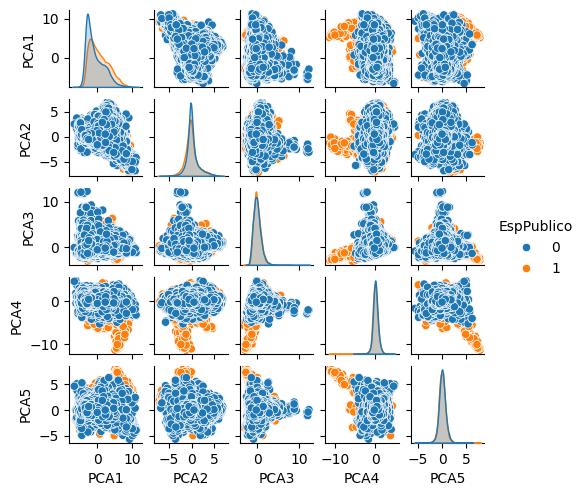

In [116]:
sns.pairplot(variables_gdf[['PCA1','PCA2','PCA3','PCA4','PCA5','EspPublico']], hue='EspPublico', size=1)

## Model construction

### Clasificadores para temperatura, humedad, población, vegetación...

In [62]:
xxx = variables_gdf[["PCA1", "PCA2", "PCA3", "PCA4","PCA5"]]
yyy = variables_gdf['EspPublico']

In [63]:
yyy.unique()

array([1, 0])

### Logistic Regression

In [64]:
x_train, x_test, y_train, y_test = train_test_split(xxx, yyy, test_size=0.3, random_state = 42)

# Reemplazar valores infinitos por NaN
x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
x_test.replace([np.inf, -np.inf], np.nan, inplace=True)

#Combinar x y y para eliminar filas con NaN de forma coherente
train_data = x_train.copy()
train_data['target'] = y_train  

#Eliminar filas con NaN en el conjunto de entrenamiento
train_data.dropna(inplace=True)

x_train_clean = train_data.drop(columns=['target'])
y_train_clean = train_data['target']

test_data = x_test.copy()
test_data['target'] = y_test
test_data.dropna(inplace=True)

x_test_clean = test_data.drop(columns=['target'])
y_test_clean = test_data['target']

#Escalar los datos:
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train_clean)
x_test_scale = scaler.transform(x_test_clean)

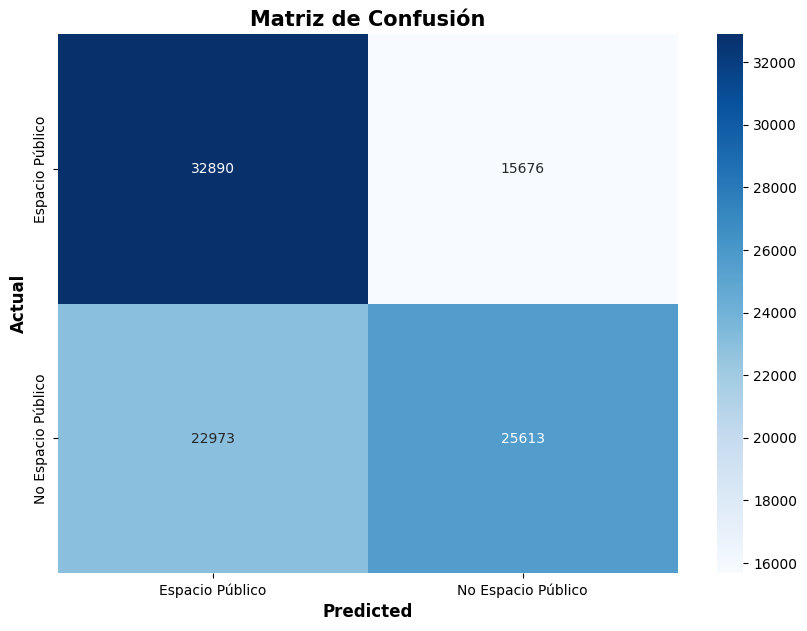

In [65]:
clf = LogisticRegression(max_iter=10000, C=1, penalty='l2', solver='sag', warm_start=True)
clf.fit(x_train_scale, y_train_clean)

y_pred = clf.predict(x_test_scale)

#Generar matriz de confusión:
cm2 = confusion_matrix(y_test_clean, y_pred)
class_labels = ['Espacio Público', 'No Espacio Público']

plt.figure(figsize=(10, 7))
sns.heatmap(cm2, annot=True, fmt="g", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Matriz de Confusión', fontsize=15, fontweight='bold')
plt.show()

In [66]:
accuracy = accuracy_score(y_test_clean, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6021800889328063


In [67]:
print(classification_report(y_test_clean, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.68      0.63     48566
           1       0.62      0.53      0.57     48586

    accuracy                           0.60     97152
   macro avg       0.60      0.60      0.60     97152
weighted avg       0.60      0.60      0.60     97152



In [68]:
'''from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np

log_reg = LogisticRegression(max_iter=1000)

# Definir el grid de hiperparámetros a ajustar
param_dist = {
    'C': np.logspace(-2, 2, 10),  # Distribución logarítmica de C
    'penalty': ['l2'],  # Usar solo penalización l2
    'solver': ['liblinear']
}

#Usar RandomizedSearchCV:
random_search = RandomizedSearchCV(estimator=log_reg, param_distributions=param_dist, 
                                   n_iter=10, cv=5, scoring='f1', verbose=1, n_jobs=-1)

random_search.fit(x_train_scale, y_train_clean)

#Usar el mejor modelo encontrado:
best_model = random_search.best_estimator_

print("Mejores hiperparámetros encontrados:", random_search.best_params_)'''


'from sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.linear_model import LogisticRegression\nimport numpy as np\n\nlog_reg = LogisticRegression(max_iter=1000)\n\n# Definir el grid de hiperparámetros a ajustar\nparam_dist = {\n    \'C\': np.logspace(-2, 2, 10),  # Distribución logarítmica de C\n    \'penalty\': [\'l2\'],  # Usar solo penalización l2\n    \'solver\': [\'liblinear\']\n}\n\n#Usar RandomizedSearchCV:\nrandom_search = RandomizedSearchCV(estimator=log_reg, param_distributions=param_dist, \n                                   n_iter=10, cv=5, scoring=\'f1\', verbose=1, n_jobs=-1)\n\nrandom_search.fit(x_train_scale, y_train_clean)\n\n#Usar el mejor modelo encontrado:\nbest_model = random_search.best_estimator_\n\nprint("Mejores hiperparámetros encontrados:", random_search.best_params_)'

### Naive Bayes

In [69]:
nb3 = GaussianNB()
nb3.fit(x_train_scale, y_train_clean)

GaussianNB()

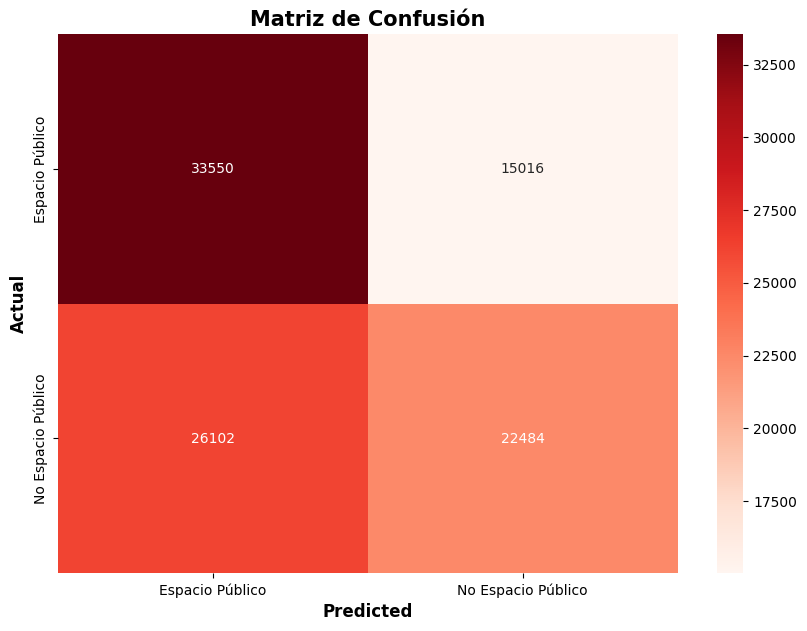

In [70]:
y_prend = nb3.predict(x_test_clean)
cm2 = confusion_matrix(y_test_clean, y_prend)
class_labels = ['Espacio Público', 'No Espacio Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [71]:
accuracy = accuracy_score(y_test_clean, y_prend)
print(f'Accuracy: {accuracy}')

Accuracy: 0.576766304347826


In [72]:
print(classification_report(y_test_clean, y_prend))

              precision    recall  f1-score   support

           0       0.56      0.69      0.62     48566
           1       0.60      0.46      0.52     48586

    accuracy                           0.58     97152
   macro avg       0.58      0.58      0.57     97152
weighted avg       0.58      0.58      0.57     97152



### Random Forest Classifier

In [73]:
rf3 = RandomForestClassifier(n_estimators = 100, random_state = 123)  
rf3.fit(x_train_scale, y_train_clean)

# Realizar predicciones en el conjunto de prueba
y_predd = rf3.predict(x_test_clean)

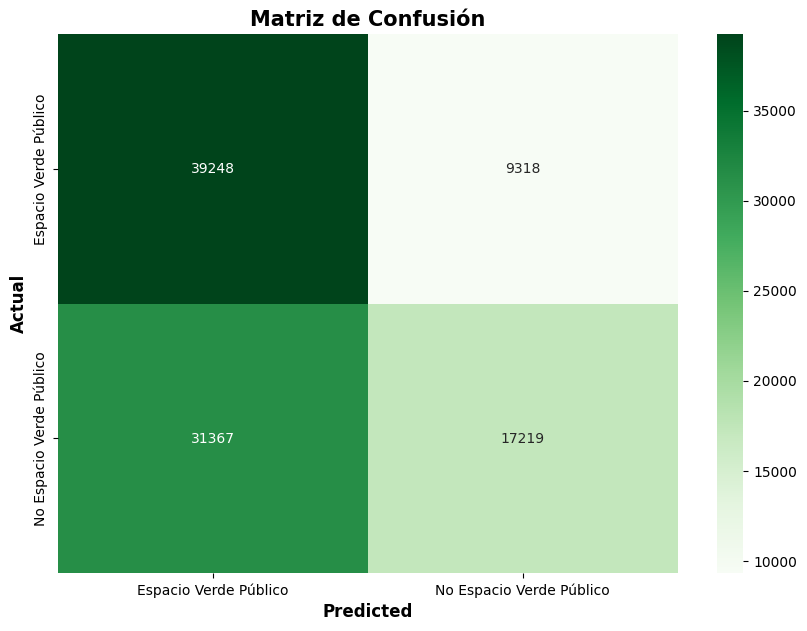

In [74]:
cm2 = confusion_matrix(y_test_clean, y_predd)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [75]:
accuracy = accuracy_score(y_test_clean, y_predd)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5812232378129117


In [76]:
print(classification_report(y_test_clean, y_predd))

              precision    recall  f1-score   support

           0       0.56      0.81      0.66     48566
           1       0.65      0.35      0.46     48586

    accuracy                           0.58     97152
   macro avg       0.60      0.58      0.56     97152
weighted avg       0.60      0.58      0.56     97152



### Ada Boost Clasifier

In [77]:
model2 = AdaBoostClassifier(n_estimators = 100)
model2.fit(x_train_scale, y_train_clean)

AdaBoostClassifier(n_estimators=100)

In [78]:
predictions2 = model2.predict(x_test_clean)
predictions2

array([0, 0, 1, ..., 1, 0, 1])

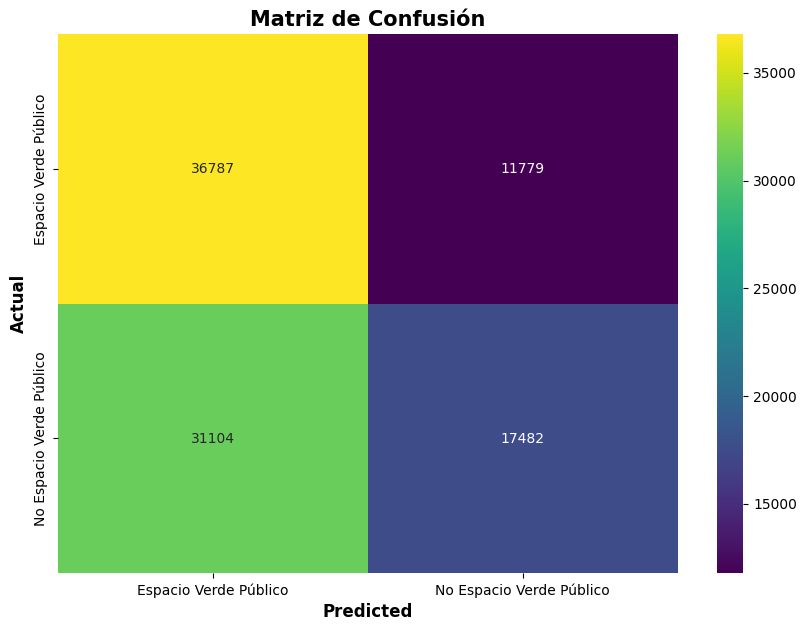

In [79]:
cm2 = confusion_matrix(y_test_clean, predictions2)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="viridis", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [80]:
print(classification_report(y_test_clean, predictions2))

              precision    recall  f1-score   support

           0       0.54      0.76      0.63     48566
           1       0.60      0.36      0.45     48586

    accuracy                           0.56     97152
   macro avg       0.57      0.56      0.54     97152
weighted avg       0.57      0.56      0.54     97152



### XGB Classifier

In [81]:
model22 = xgb.XGBClassifier()
model22.fit(x_train_scale, y_train_clean)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [82]:
predictions22 = model22.predict(x_test_clean)
predictions22

array([0, 0, 1, ..., 1, 0, 0])

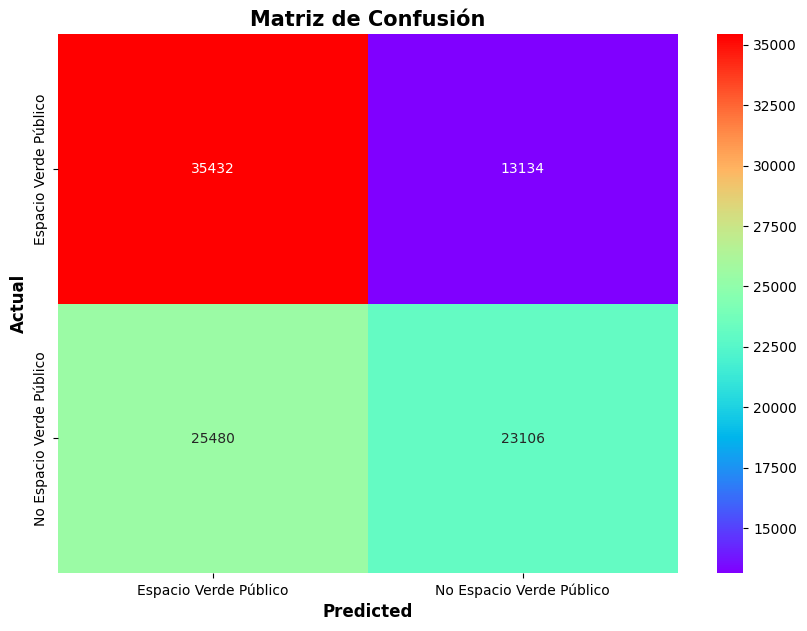

In [83]:
cm2 = confusion_matrix(y_test_clean, predictions22)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="rainbow", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [84]:
print(classification_report(y_test_clean, predictions22))

              precision    recall  f1-score   support

           0       0.58      0.73      0.65     48566
           1       0.64      0.48      0.54     48586

    accuracy                           0.60     97152
   macro avg       0.61      0.60      0.60     97152
weighted avg       0.61      0.60      0.60     97152



In [85]:
accuracy = accuracy_score(y_test_clean, predictions22)
print(f'Accuracy: {accuracy}')

Accuracy: 0.60254034914361


### Decision Tree Classfier

In [86]:
from sklearn.tree import DecisionTreeClassifier

In [87]:
model32 = DecisionTreeClassifier()
model32.fit(x_train_scale, y_train_clean)

DecisionTreeClassifier()

In [88]:
predictions32 = model32.predict(x_test_clean)
predictions32

array([1, 1, 0, ..., 1, 1, 0])

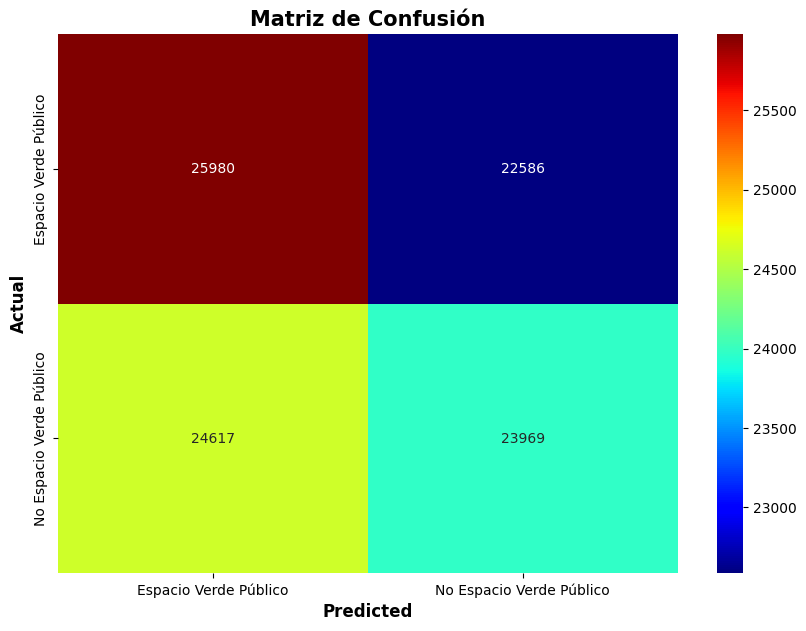

In [89]:
cm2 = confusion_matrix(y_test_clean, predictions32)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="jet", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [90]:
print(classification_report(y_test_clean, predictions32))

              precision    recall  f1-score   support

           0       0.51      0.53      0.52     48566
           1       0.51      0.49      0.50     48586

    accuracy                           0.51     97152
   macro avg       0.51      0.51      0.51     97152
weighted avg       0.51      0.51      0.51     97152



In [91]:
accuracy = accuracy_score(y_test_clean, predictions32)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5141324934123848


In [92]:
from sklearn.linear_model import SGDClassifier

In [93]:
modell32 = SGDClassifier()
modell32.fit(x_train_scale, y_train_clean)

SGDClassifier()

In [94]:
predictions32 = modell32.predict(x_test_clean)
predictions32

array([0, 0, 1, ..., 1, 0, 1])

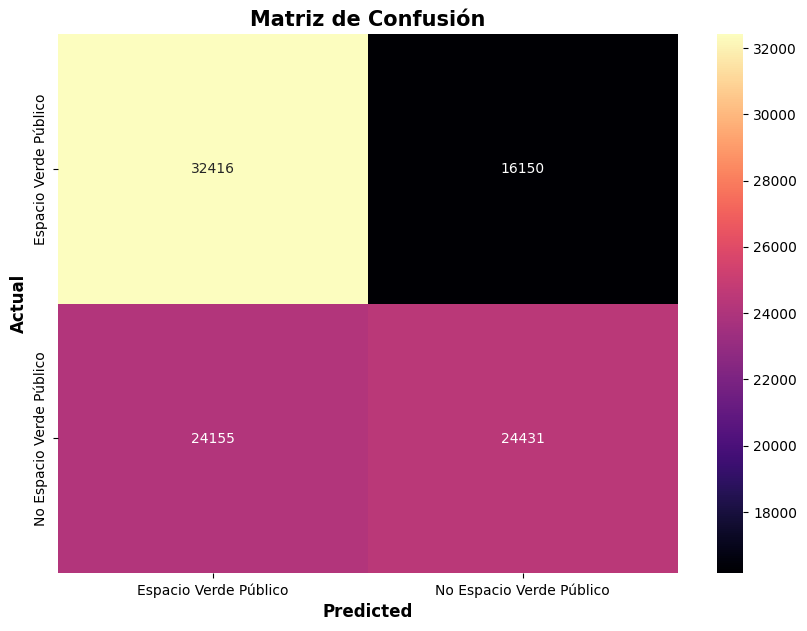

In [95]:
cm2 = confusion_matrix(y_test_clean, predictions32)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="magma", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [96]:
print(classification_report(y_test_clean, predictions32))

              precision    recall  f1-score   support

           0       0.57      0.67      0.62     48566
           1       0.60      0.50      0.55     48586

    accuracy                           0.59     97152
   macro avg       0.59      0.59      0.58     97152
weighted avg       0.59      0.59      0.58     97152



In [97]:
accuracy = accuracy_score(y_test_clean, predictions32)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5851346343873518
